# TP Integrador

Detección de anomalías en escáneres de rayos X de equipajes mediante aprendizaje profundo. El modelo identifica 5 objetos potencialmente peligrosos: pistola, cuchillo, alicates, tijeras y llave inglesa, lo que facilita la vigilancia inteligente en los sistemas de seguridad de los aeropuertos.

Data set: https://www.kaggle.com/datasets/orvile/x-ray-baggage-anomaly-detection/data

## Integrantes:
- Martin Paz
- Matias Tripode

## 1) Cargar el Dataset

In [ ]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

# Clonar YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

%pip install albumentations opencv-python-headless


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

In [ ]:
%cd /content/

/content


In [ ]:

# https://drive.google.com/file/d/19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI/view?usp=drive_link

# El ID sera: 19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI
!gdown --id 19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI

!unzip x-ray-baggage-anomaly-detection.zip > /dev/null

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI
From (redirected): https://drive.google.com/uc?id=19N6Q7qRJMzfro47SBCc0PY8pUXnPZOhI&confirm=t&uuid=92a8263a-4445-456f-b52a-3a6f92d4d8ca
To: /content/x-ray-baggage-anomaly-detection.zip
100% 140M/140M [00:01<00:00, 81.9MB/s]


## 2) EDA

**Problema a resolver**
Detección y clasificación de objetos potencialmente peligrosos: pistola, cuchillo, alicates, tijeras y llave ingles en imagenes de scanner a equipajes en aeropuertos. Las métricas a utilizar deben considerar tanto la precisión de la clase como la localización del objeto (bounding box).


El analisis EDA se compone de los siguientes items:

1. Entendiento la estructura del dataset
2. Cuantas clases distintas tenemos?
3. Visualización preliminar de algunos los datos
4. Análisis de Distribución de Clases
5. Análisis del tamaño de las imágenes
6. Verificar si hay fotos sin etiquetas
7. Análisis de Bounding Boxes por clase
8. CONCLUSIONES


### 1). Entendiento la estructura del dataset

Primero vamos a entder la extractura del dataset. Vemos que tiene tres carpetas `test`, `train` y `valid`. Dentro de cada una tienen `images` and labels.
Como ejemplo:
```
train/
├── images/
│   └── 009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a.jpg
└── labels/
    └── 009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a.txt
```

Los archivos `labels` contienen una sola linea con formato:
 <class_id> <x_center> <y_center> <width> <height>

Ejemplo:

`2 0.6538461538461539 0.5420673076923077 0.0625 0.06610576923076923`





### 2). Cuantas clases distintas tenemos?

In [ ]:
def analyze_classes(labels_folder):
    class_ids = set()
    for label_file in os.listdir(labels_folder):
        with open(os.path.join(labels_folder, label_file), 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_ids.add(class_id)

    print(f"Identificador de clase: {sorted(class_ids)}")
    return sorted(class_ids)

class_ids = analyze_classes('./train/labels')

Identificador de clase: [0, 1, 2, 3, 4]


Vemos que hay **5 clases** diferentes indicadas con numeros: `0, 1, 2, 3, 4`

### 3). Visualización preliminar de algunos los datos

Vamos a visualizar una imagen de cada clase, tomada al azar, del conjunto de entrenamiento. Esto es para tener nocion de como lucen las imágenes de nuestro set de datos. Esto nos ayudará a saber que tipos de transformaciones serán más útiles cuando realicemos data augmentation.

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Configuración de paths
train_images_path = './train/images'
train_labels_path = './train/labels'

def graficar_ejemplos(train_images_path, train_labels_path):
  # Crear un diccionario para organizar las imágenes por clase
  class_images = {class_id: [] for class_id in range(5)}  # Asumiendo 5 clases (0-4)
  # Leer todas las imágenes y organizarlas por clase
  for label_file in os.listdir(train_labels_path):
      if not label_file.endswith('.txt'):
          continue

      # Obtener el path de la imagen correspondiente
      image_file = label_file.replace('.txt', '.jpg')
      image_path = os.path.join(train_images_path, image_file)

      # Leer las anotaciones y registrar todas las clases presentes
      with open(os.path.join(train_labels_path, label_file), 'r') as f:
          for line in f:
              class_id = int(line.strip().split()[0])
              if image_path not in class_images[class_id]:  # Evitar duplicados
                  class_images[class_id].append(image_path)

  # Configurar el gráfico
  plt.figure(figsize=(80, 65))

  # Para cada clase
  for class_id in sorted(class_images.keys()):
      # Tomar 4 imágenes aleatorias (o menos si no hay suficientes)
      sample_images = random.sample(class_images[class_id], min(4, len(class_images[class_id])))

      # Mostrar cada imagen
      for i, image_path in enumerate(sample_images):
          # Leer la imagen
          img = cv2.imread(image_path)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          height, width = img.shape[:2]

          # Configurar subplot
          ax = plt.subplot(5, 4, class_id*4 + i + 1)
          plt.imshow(img)
          plt.title(f'Clase {class_id}\n{os.path.basename(image_path)[:10]}...')
          plt.axis('off')

          # Leer el archivo de anotaciones y dibujar los bounding boxes
          label_path = image_path.replace('.jpg', '.txt').replace('images', 'labels')
          if os.path.exists(label_path):
              with open(label_path, 'r') as f:
                  for line in f:
                      parts = line.strip().split()
                      current_class = int(parts[0])

                      # Solo dibujar bounding boxes de la clase actual
                      if current_class == class_id:
                          x_center = float(parts[1]) * width
                          y_center = float(parts[2]) * height
                          box_width = float(parts[3]) * width
                          box_height = float(parts[4]) * height

                          # Calcular coordenadas del bounding box
                          x_min = x_center - (box_width / 2)
                          y_min = y_center - (box_height / 2)

                          # Crear el rectángulo
                          rect = patches.Rectangle(
                              (x_min, y_min), box_width, box_height,
                              linewidth=2, edgecolor='red', facecolor='none')
                          ax.add_patch(rect)
  plt.tight_layout()
  plt.suptitle('Ejemplos de Imágenes por Clase con Bounding Boxes', y=1.02, fontsize=16)
  plt.show()


graficar_ejemplos(train_images_path, train_labels_path)

### 4). Análisis de Distribución de Clases
Ahora vamos a analizar la distribución de clases. Esto nos puede ayudar a identificar posibles desbalances entre clases.

Distribución de clases:
Clase 0: 1284 instancias
Clase 1: 1393 instancias
Clase 2: 698 instancias
Clase 3: 1379 instancias
Clase 4: 1427 instancias
----


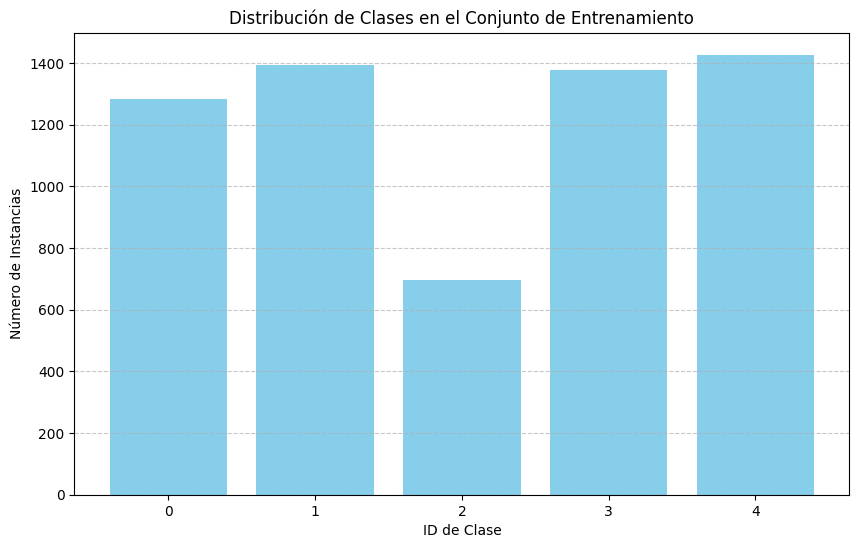

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import Counter

def analizar_distribucion_clases(ruta_etiquetas):
    # Contador para almacenar la frecuencia de cada clase
    contador_clases = Counter()

    # Recorrer todos los archivos de etiquetas
    for archivo_etiqueta in os.listdir(ruta_etiquetas):
        ruta_completa = os.path.join(ruta_etiquetas, archivo_etiqueta)

        try:
            with open(ruta_completa, 'r') as f:
                for linea in f:
                    # Cada línea representa un objeto en la imagen
                    clase_id = int(linea.strip().split()[0])
                    contador_clases[clase_id] += 1
        except Exception as e:
            print(f"Error procesando {archivo_etiqueta}: {e}")

    return contador_clases

# Ruta a las etiquetas de entrenamiento
ruta_etiquetas_train = './train/labels'

# Obtener distribución de clases
distribucion = analizar_distribucion_clases(ruta_etiquetas_train)

# Mostrar resultados
print("Distribución de clases:")
for clase_id, conteo in sorted(distribucion.items()):
    print(f"Clase {clase_id}: {conteo} instancias")

print("----")
# Visualización
plt.figure(figsize=(10, 6))
plt.bar(distribucion.keys(), distribucion.values(), color='skyblue')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('ID de Clase')
plt.ylabel('Número de Instancias')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Si conocemos los nombres de las clases, podemos personalizar los labels
# nombres_clases = {0: "Normal", 1: "Arma", 2: "Explosivo", ...}
# plt.xticks(list(nombres_clases.values()))

plt.show()

Vemos que Clase 2 tiene significativamente menos instancias (698) comparado con las demás. Las otras clases están relativamente balanceadas (1284-1427 instancias)

### 5). Análisis del tamaño de las imágenes

In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def medir_las_fotos(carpeta_imagenes):
    print("Chequeando los tamaños de las fotos...")

    tamaños = defaultdict(int)
    problemas = []

    for archivo in os.listdir(carpeta_imagenes):
        try:
            # Leemos la imagen como si fuera un chori
            img = cv2.imread(os.path.join(carpeta_imagenes, archivo))
            if img is None:
                problemas.append(archivo)
                continue

            alto, ancho = img.shape[:2]
            tamaños[(ancho, alto)] += 1

        except Exception as e:
            print(f"Error con {archivo}: {e}")
            problemas.append(archivo)

    # Mostramos los resultados
    print("\nResumen de tamaños:")
    for tam, cant in sorted(tamaños.items()):
        print(f"Tamaño {tam}: {cant} fotos ({cant/len(os.listdir(carpeta_imagenes))*100:.1f}%)")

    if problemas:
        print(f"\n Error {len(problemas)} fotos (no se pudieron leer)")

    return tamaños, problemas

carpeta_train = './train/images'
tamaños, fotos_defectuosas = medir_las_fotos(carpeta_train)

Chequeando los tamaños de las fotos...

Resumen de tamaños:
Tamaño (416, 416): 6181 fotos (100.0%)


Vemos que todas las `6181` (1284 + 1393+ 698 + 1379+ 1427) fotos tienen el mismo tamaño ` (416, 416)`

### 6). Verificar si hay fotos sin etiquetas

In [ ]:
def comparar_con_y_sin_anotaciones(carpeta_imagenes, carpeta_etiquetas, ejemplos=5):
    print("\n Comparando fotos con y sin anotaciones...")

    # Buscamos fotos que tengan y no tengan anotaciones
    fotos_con_anotaciones = []
    fotos_sin_anotaciones = []

    todas_fotos = set(os.listdir(carpeta_imagenes))
    fotos_etiquetadas = set([f.replace('.txt', '.jpg') for f in os.listdir(carpeta_etiquetas)])

    fotos_sin_anotaciones = list(todas_fotos - fotos_etiquetadas)
    fotos_con_anotaciones = list(fotos_etiquetadas)

    print(f"Total fotos: {len(todas_fotos)}")
    print(f"Fotos con anotaciones: {len(fotos_con_anotaciones)}")
    print(f"Fotos sin anotaciones: {len(fotos_sin_anotaciones)}")

carpeta_etiquetas = './train/labels'
comparar_con_y_sin_anotaciones(carpeta_train, carpeta_etiquetas)


 Comparando fotos con y sin anotaciones...
Total fotos: 6181
Fotos con anotaciones: 6181
Fotos sin anotaciones: 0


Vemos que todas las fotos tienen sus etiquetas!

### 7) Análisis de Bounding Boxes por Clase

Con este análisis buscamos: Saber si hay características que nos pueda ayudar a distinguir objetos dependiendo de las clases.

Para cada clase y los bounding boxes queremos entender:

- Proporción de objetos pequeños (área del box < 1% del área de la imagen)
- Aspect ratios atípicos (ancho/alto < 0.2 o > 5.0)
- Promedio de objetos peligrosos por imagen

In [ ]:
from glob import glob
import os
from collections import defaultdict
import numpy as np

image_paths = sorted(glob('./train/images/*.jpg'))
label_paths = sorted(glob('./train/labels/*.txt'))

# Inicialización
small_object_threshold = 0.01  # 1%
aspect_ratio_threshold_low = 0.2
aspect_ratio_threshold_high = 5.0

class_stats = {
    i: {
        "total": 0,
        "small": 0,
        "weird_aspect_ratio": 0,
        "images": set()
    } for i in range(5)
}

# Total imágenes con al menos un objeto
images_with_objects = 0
total_objects = 0

for label_path in label_paths:
    with open(label_path, 'r') as f:
        lines = f.readlines()
        if not lines:
            continue  # sin objetos
        images_with_objects += 1

        for line in lines:
            try:
                class_id, x_c, y_c, w_box, h_box = map(float, line.strip().split())
                class_id = int(class_id)
            except:
                continue

            area = w_box * h_box
            aspect_ratio = w_box / h_box if h_box > 0 else 0

            class_stats[class_id]["total"] += 1
            total_objects += 1

            if area < small_object_threshold:
                class_stats[class_id]["small"] += 1

            if aspect_ratio < aspect_ratio_threshold_low or aspect_ratio > aspect_ratio_threshold_high:
                class_stats[class_id]["weird_aspect_ratio"] += 1

            # Registrar que esta clase aparece en esta imagen
            class_stats[class_id]["images"].add(label_path)

# Mostrar resultados
for class_id, stats in class_stats.items():
    total = stats["total"]
    if total == 0:
        print(f"Clase {class_id}: sin objetos etiquetados.\n")
        continue

    small_pct = 100 * stats["small"] / total
    weird_ar_pct = 100 * stats["weird_aspect_ratio"] / total
    avg_per_image = total / len(stats["images"])

    print(f"Clase {class_id}")
    print(f"- Total objetos: {total}")
    print(f"- % Objetos pequeños (<1%): {small_pct:.2f}%")
    print(f"- % Aspect ratio atípico: {weird_ar_pct:.2f}%")
    print(f"- Promedio objetos por imagen (con esa clase): {avg_per_image:.2f}")
    print()

print(f"Promedio general de objetos peligrosos por imagen: {total_objects / images_with_objects:.2f}")


Clase 0
- Total objetos: 1284
- % Objetos pequeños (<1%): 19.55%
- % Aspect ratio atípico: 0.78%
- Promedio objetos por imagen (con esa clase): 1.00

Clase 1
- Total objetos: 1393
- % Objetos pequeños (<1%): 80.62%
- % Aspect ratio atípico: 1.79%
- Promedio objetos por imagen (con esa clase): 1.00

Clase 2
- Total objetos: 698
- % Objetos pequeños (<1%): 67.91%
- % Aspect ratio atípico: 10.32%
- Promedio objetos por imagen (con esa clase): 1.00

Clase 3
- Total objetos: 1379
- % Objetos pequeños (<1%): 49.75%
- % Aspect ratio atípico: 5.73%
- Promedio objetos por imagen (con esa clase): 1.00

Clase 4
- Total objetos: 1427
- % Objetos pequeños (<1%): 78.70%
- % Aspect ratio atípico: 0.21%
- Promedio objetos por imagen (con esa clase): 1.00

Promedio general de objetos peligrosos por imagen: 1.00




**7.1) Objetos pequeños (<1%)**
- La Clase 0 tiene solo 19.55% de objetos pequeños.
- La Clase 1 tiene 80.62% de objetos pequeños.
- La Clase 2 también es bastante alta: 67.91%.
- La Clase 3 tiene solo 5.73% objetos pequeños.
- La Clase 4 tiene 78.70% de objetos pequeños.

`Conclusion`
Las clases 1, 2 y 4 tienen un alto porcentaje de objetos pequeños. Esto indicaría que deberíamos aplicar algún escalado que mejore la detección de objetos pequeños para estas clases.

**7.2) Aspect ratios atípicos (<0.2 o >5)**
La Clase 2 destaca con 10.32% de aspect ratios extremos → tal vez herramientas largas o estrechas. El resto está bastante bajo, especialmente Clase 4: solo 0.21%.

`Conclusion`
No vemos nada relevante que nos ayude a distinguir objetos de una clase dado aspect ratios atípicos.


**7.3) Promedio de objetos por imagen = 1.00**
Hay exactamente un solo objeto por imagen.
`Conclusion**
Solo tenemos que enfocarnos en detectar un elemento peligroso por imagen.


### 8). CONCLUSIONES

- `Distribución de las clases`: Vemos que Clase 2 tiene significativamente menos instancias (698) comparado con las demás. Las otras clases están relativamente balanceadas (1284-1427 instancias). Deberíamos aplicar data augmentation a la clase 2 para que no esté desbalanceada con respecto al resto de clases.
- `Tamaño de las imágenes`: Vemos que todas las 6181 imágenes tienen el mismo tamaño (416, 416)
- Aplicar un escalado para detectar objetos pequeños en las clases 1, 2 y 4.



--------------------------

## 3) Basedline YOLO5s y YOLO5m

Las dos arquitecturas elegidas para realizar el baseline son: `Yolo5s` y `Yolo5m`.

- Vamos a aumentar la clase dos llevandola al doble de imanges, esto va a balancearla con respecto a las otras clases.
- Vamos a ejecutar `50 epochs`.
- Por cada modelo y cada clase las `metricas` que vamos a considerar van a ser:
  - `mAP50` y `mAP50-95`
  - `Precision` y `Recall`



## YOLOv5

## Aplicar Augmentation solo a la clase 2

Vamos a realizar augmentation solo a la clase 2, ya que es la unica desbalanceada.
Realizaremos un augmentation por cada imagen eso nos llevara a balancearla con respecto al resto, quedan asi todas las clases con ~1200 imagenes cada una.

La augmentation aplicada es:
```
transform = A.Compose([
        A.HorizontalFlip(p=0.5), # Voltea la imagen horizontalmente (espejo).
        A.RandomScale(scale_limit=0.2, p=0.5), #  Escala la imagen aleatoriamente entre ±20% de su tamaño original.
        A.Rotate(limit=10, p=0.3), # Rota la imagen hasta ±10 grados.
        A.RandomBrightnessContrast(p=0.3), # Ajusta brillo y contraste aleatoriamente (30% de probabilidad).
        A.Resize(height=416, width=416), # Redimensiona la imagen a 416x416
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
```

In [ ]:
%cd /content/
!ls

/content
data.yaml	     sample_data  x-ray-baggage-anomaly-detection.zip
drive		     test	  yolov5
README.dataset.txt   train
README.roboflow.txt  valid


In [ ]:
import os
import cv2
import albumentations as A
import shutil
import random
import numpy as np
import albumentations as A

def augment_class2_images(image_dir, label_dir, output_img_dir, output_lbl_dir):
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    # Fijar la semilla, para que siempre genere las mismas imagenes.
    seed = 42
    random.seed(seed)
    np.random.seed(seed)

    transform = A.Compose([
        A.HorizontalFlip(p=0.5), # Voltea la imagen horizontalmente (espejo).
        A.RandomScale(scale_limit=0.2, p=0.5), #  Escala la imagen aleatoriamente entre ±20% de su tamaño original.
        A.Rotate(limit=10, p=0.3), # Rota la imagen hasta ±10 grados.
        A.RandomBrightnessContrast(p=0.3), # Ajusta brillo y contraste aleatoriamente (30% de probabilidad).
        A.Resize(height=416, width=416), # Redimensiona la imagen a 416x416
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    for filename in os.listdir(label_dir):
        if not filename.endswith('.txt'):
            continue

        label_path = os.path.join(label_dir, filename)
        image_name = filename.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()

        classes = [int(line.strip().split()[0]) for line in lines]
        if not all(c == 2 for c in classes):  # filtramos por clase 2
            continue

        bboxes = [list(map(float, line.strip().split()[1:])) for line in lines]
        class_labels = ['2'] * len(bboxes)

        image = cv2.imread(image_path)
        h, w = image.shape[:2]

        try:
            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        except:
            print(f'Error augmenting {image_path}')
            continue

        new_img = augmented['image']
        new_bboxes = augmented['bboxes']

        new_img_name = image_name.replace('.jpg', '_aug.jpg')
        new_lbl_name = filename.replace('.txt', '_aug.txt')

        cv2.imwrite(os.path.join(output_img_dir, new_img_name), new_img)

        with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
            for box in new_bboxes:
                f.write(f"2 {' '.join(map(str, box))}\n")

        print(f"Aumentada: {new_img_name}")



In [ ]:
%cd /content/



/content


In [ ]:
augment_class2_images(
    image_dir='/content/train/images/',
    label_dir='/content/train/labels/',
    output_img_dir='/content/train_augmented/images/',
    output_lbl_dir='/content/train_augmented/labels/'
)

In [ ]:
# COPIAR LAS IMAGENES AUTMENTADAS
!mv ./train_augmented/images/* ./train/images/
!mv ./train_augmented/labels/* ./train/labels/


## Graficar Imagenes aumentadas

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Ruta a tus imágenes y etiquetas aumentadas
aug_img_dir = './train/images/train_augmented'
aug_lbl_dir = './train/labels/train_augmented'

# Obtener los primeros 5 archivos de imagen
image_files = [f for f in os.listdir(aug_img_dir) if f.endswith('.jpg') or f.endswith('.png')][:5]

def plot_image_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, xc, yc, bw, bh = map(float, line.strip().split())
                # Convertir coordenadas normalizadas a píxeles
                x1 = int((xc - bw/2) * w)
                y1 = int((yc - bh/2) * h)
                x2 = int((xc + bw/2) * w)
                y2 = int((yc + bh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    return img

# Mostrar imágenes
plt.figure(figsize=(16, 10))
for idx, img_file in enumerate(image_files):
    img_path = os.path.join(aug_img_dir, img_file)
    label_path = os.path.join(aug_lbl_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
    img = plot_image_with_boxes(img_path, label_path)
    plt.subplot(1, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_file[:15] + '...')
plt.tight_layout()
plt.show()


### Copiar imagenes aumentadas al dataset de entrenamiento

In [ ]:
# Por ahora no vamos a utilizar augmentation
!mv ./train/images/train_augmented/* ./train/images/
!mv ./train/labels/train_augmented/* ./train/labels/


mv: cannot stat './train/images/train_augmented/*': No such file or directory
mv: cannot stat './train/labels/train_augmented/*': No such file or directory


In [ ]:
!mv data.yaml ./yolov5

In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!ls

benchmarks.py	 data.yaml   models	       runs	       val.py
CITATION.cff	 detect.py   pyproject.toml    segment
classify	 export.py   README.md	       train.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md   tutorial.ipynb
data		 LICENSE     requirements.txt  utils


### Ejecutar YOLO5s

In [ ]:
!python train.py \
  --img 416 \
  --batch 32 \
  --epochs 50 \
  --data data.yaml \
  --cfg models/yolov5s.yaml \
  --weights yolov5s.pt \
  --name yolov5s_augmented_clase2_batch32_epoch50_v1 \
  --cache

### Ejecutar YOLOR5m

In [ ]:
!python train.py \
  --img 416 \
  --batch 32 \
  --epochs 50 \
  --data data.yaml \
  --weights yolov5m.pt \
  --cfg models/yolov5m.yaml \
  --cache \
  --name yolov5m_augmented_clase2_batch32_epoch50_v1_1_50

--------------------------------------------------

### Evaluar Modelos

Evaluar `YOLO5m`

In [ ]:
!python val.py \
  --weights runs/train/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50/weights/best.pt \
  --data data.yaml \
  --img 416 \
  --task val

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
val: data=data.yaml, weights=['runs/train/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20869098 parameters, 0 gradients, 47.9 GFLOPs
100% 755k/755k [00:00<00:00, 14.3MB/s]
val: Scanning /content/valid/labels... 1766 images, 0 backgrounds, 0 cor

Evaluar `YOLO5s`

In [ ]:
!python val.py \
  --weights runs/train/yolov5s_augmented_clase2_batch32_epoch50_v1/weights/best.pt \
  --data data.yaml \
  --img 416 \
  --task val

val: data=data.yaml, weights=['runs/train/yolov5s_augmented_clase2_batch32_epoch50_v1/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/valid/labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% 1766/1766 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 56/56 [00:13<00:00,  4.00it/s]
                   all       1766       1766      0.871      0.836      0.858      0.368
                     0       1766        391      0.968      0.977      0.974      0.499
        

### TensorBoard: comparar gráficamente muchos experimentos

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/train


### Ver Predicciones con Imagenes Reales

In [ ]:
%cd ./yolov5

/content/yolov5


In [ ]:
!python detect.py \
  --weights runs/train/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50/weights/best.pt \
  --img 416 \
  --conf 0.25 \
  --source ../test/images

### Mostrar las primeras 5 imagenes con predicciones

In [ ]:
import os
from IPython.display import Image, display

# Muestra las primeras 5 imágenes con predicciones
for filename in os.listdir('runs/detect/exp3')[:50]:
    display(Image(filename=f"runs/detect/exp3/{filename}"))

### Funciones para copiar directorios y archivos desde y hace google-drive

In [ ]:
def copy_directorio(source_path, destination_path):
  if not os.path.exists(destination_path):
        os.makedirs(destination_path)

  if os.path.exists(source_path):
      try:
        print(f"✔ Inicio copiado en: {destination_path}")
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True) # copia directorios
        print(f"✔ Checkpoints guardados en: {destination_path}")
      except FileExistsError:
        print(f"No se encontró el directorio: {source_path}")
  else:
      print(f"No se encontró el directorio: {source_path}")

In [ ]:
def save_file(exp_name, source_path, destination_path):
  if not os.path.exists(destination_path):
        os.makedirs(destination_path)

  if os.path.exists(destination_path):

      shutil.copy2(os.path.join(source_path, exp_name), os.path.join(destination_path, exp_name)) # copia archivos
      print(f"Checkpoints guardados en: {destination_path}")
  else:
      print(f"No se encontró el directorio: {src_path}")

#### Obtener checkpoints desde Google Drive al Colab

#### Guardar experimentos en Google Drive

In [ ]:
%cd /content/
!ls

/content
drive  sample_data  yolov5


In [ ]:
from google.colab import drive
import shutil
import os

# 1. Montar Google Drive
drive.mount('/content/drive')

copy_directorio('/content/drive/MyDrive/yolov5_checkpoints/yolov5s_augmented_clase2_batch32_epoch50_v1/', '/content/yolov5/runs/train/yolov5s_augmented_clase2_batch32_epoch50_v1')
copy_directorio('/content/drive/MyDrive/yolov5_checkpoints/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50/', '/content/yolov5/runs/train/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50')


Mounted at /content/drive
✔ Inicio copiado en: /content/yolov5/runs/train/yolov5s_augmented_clase2_batch32_epoch50_v1
✔ Checkpoints guardados en: /content/yolov5/runs/train/yolov5s_augmented_clase2_batch32_epoch50_v1
✔ Inicio copiado en: /content/yolov5/runs/train/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50
✔ Checkpoints guardados en: /content/yolov5/runs/train/yolov5m_augmented_clase2_batch32_epoch50_v1_1_50


## Visualizar `Métricas Globales` para ambos modelos (mAP, precisión, etc.)

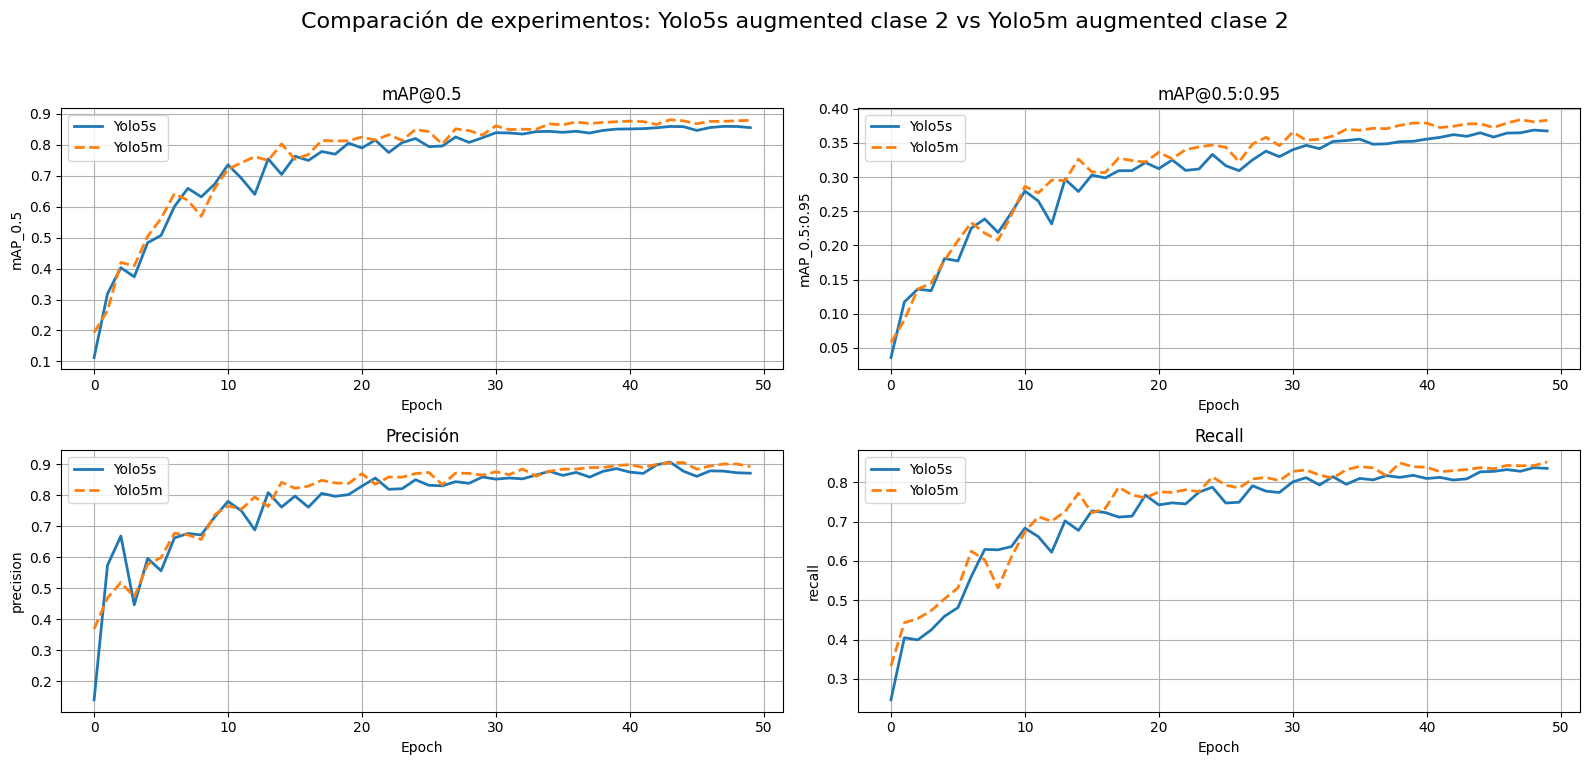

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def comparar_experimentos(exp1, exp2):
    def cargar_resultados(exp):
        path = f'runs/train/{exp}/results.csv'
        df = pd.read_csv(path)
        df.columns = df.columns.str.strip()  # Limpiar espacios
        return df

    df1 = cargar_resultados(exp1)
    df2 = cargar_resultados(exp2)

    metrics = ['metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'metrics/precision', 'metrics/recall']
    titulos = ['mAP@0.5', 'mAP@0.5:0.95', 'Precisión', 'Recall']

    plt.figure(figsize=(16, 8))
    for i, (metric, titulo) in enumerate(zip(metrics, titulos)):
        plt.subplot(2, 2, i + 1)
        plt.plot(df1[metric], label='Yolo5s', linewidth=2)
        plt.plot(df2[metric], label='Yolo5m', linewidth=2, linestyle='--')
        plt.title(titulo)
        plt.xlabel('Epoch')
        plt.ylabel(metric.split('/')[-1])
        plt.grid(True)
        plt.legend()
    exp1_title = 'Yolo5s augmented clase 2'
    exp2_title = 'Yolo5m augmented clase 2'

    plt.suptitle(f'Comparación de experimentos: {exp1_title} vs {exp2_title}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

experiments = ['yolov5s_augmented_clase2_batch32_epoch50_v1', 'yolov5m_augmented_clase2_batch32_epoch50_v1_1_50']

comparar_experimentos(experiments[0], experiments[1])

### **Análisis Comparativo: YOLOv5m vs YOLOv5s**

#### **1. Métricas Globales**
| **Métrica**       | **YOLOv5m** | **YOLOv5s** | **Diferencia** |
|-------------------|-------------|-------------|----------------|
| **Precisión (P)** | 0.900       | 0.871       | +3.3% (m)      |
| **Recall (R)**    | 0.841       | 0.836       | +0.5% (m)      |
| **mAP@0.5**      | 0.875       | 0.858       | +1.7% (m)      |
| **mAP@0.5:0.95** | 0.384       | 0.368       | +4.3% (m)      |
| **Velocidad**     | 2.58 it/s   | 4.00 it/s   | +55% (s)       |

#### **Vemos que**
1. **YOLOv5m** supera a YOLOv5s en precisión (+3.3%) y mAP (+1.7-4.3%)
2. **YOLOv5s** es un 55% más rápido (4.00 it/s vs 2.58 it/s)
---

#### **2. Análisis Detallado por Clase**


**YOLOv5m**:

| Class | Images | Instances | P     | R     | mAP50 | mAP50-95 |
|-------|--------|-----------|-------|-------|-------|----------|
| all   | 1766   | 1766      | 0.900 | 0.841 | 0.875 | 0.384    |
| 0     | 1766   | 391       | 0.983 | 0.985 | 0.984 | 0.509    |
| 1     | 1766   | 389       | 0.909 | 0.900 | 0.908 | 0.376    |
| 2     | 1766   | 225       | 0.864 | 0.551 | 0.706 | 0.261    |
| 3     | 1766   | 366       | 0.814 | 0.844 | 0.847 | 0.382    |
| 4     | 1766   | 395       | 0.928 | 0.927 | 0.932 | 0.392    |

**YOLOv5s**:

| Class | Images | Instances | P     | R     | mAP50 | mAP50-95 |
|-------|--------|-----------|-------|-------|-------|----------|
| all   | 1766   | 1766      | 0.871 | 0.836 | 0.858 | 0.368    |
| 0     | 1766   | 391       | 0.968 | 0.977 | 0.974 | 0.499    |
| 1     | 1766   | 389       | 0.874 | 0.915 | 0.915 | 0.374    |
| 2     | 1766   | 225       | 0.779 | 0.565 | 0.653 | 0.236    |
| 3     | 1766   | 366       | 0.812 | 0.791 | 0.822 | 0.356    |
| 4     | 1766   | 395       | 0.919 | 0.929 | 0.923 | 0.377    |

---

#### **De las tablas vemos que**
1. **Clase 2** tiene bajo recall en ambos modelos (~55%)
2. **Clases 0 y 4** muestran excelente rendimiento en ambos modelos
3. **Clase 1** muestra `mAP50-95` bajo
4. **Clase 3** precisión baja (81%).

La clase de menor performance es la **Clase 2**
#### Haciendo double click en la **Clase 2**

| Métrica       | YOLOv5m | YOLOv5s | Diferencia | Interpretación |
|--------------|---------|---------|------------|----------------|
| Precisión (P) | 0.864   | 0.779   | +10.9%     | YOLOv5m comete menos errores |
| Recall (R)    | 0.551   | 0.565   | -2.5%      | Ambos modelos pierden ~45% de objetos |
| mAP50        | 0.706   | 0.653   | +8.1%      | Problemas significativos |
| mAP50-95     | 0.261   | 0.236   | +10.6%     | Los bounding boxes predichos no se ajustan bien a los objetos reales. |

-------------------------------------

## Pasos Siguientes
- Determinar como podemos mejorar la performance de la **Clase 2**